In [1]:
pip install --pre dgl-cu116 -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 7.0 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [2]:
import torch
import dgl
from dgl.data import CoraGraphDataset #Data 1
from dgl.data import RedditDataset #Data 2
#from dgl.data import PPIDataset #Data 3 (Not working)

from dgl.nn import SAGEConv

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

import scipy
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
scipy.__version__

'1.7.3'

In [4]:
dgl.__version__

'1.0a230116'

In [5]:
torch.__version__

'1.13.1+cu116'

In [6]:
dataset1 = CoraGraphDataset(verbose=True)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [7]:
dataset2 = RedditDataset(self_loop=False, verbose=True)

Extracting file to /root/.dgl/reddit
Finished data loading.
  NumNodes: 232965
  NumEdges: 114615892
  NumFeats: 602
  NumClasses: 41
  NumTrainingSamples: 153431
  NumValidationSamples: 23831
  NumTestSamples: 55703
Done saving data into cached files.


In [8]:
torch.cuda.is_available()

True

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
class SAGE(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GraphSAGE-mean
        self.layers.append(SAGEConv(in_size, hid_size, "gcn"))
        self.layers.append(SAGEConv(hid_size, out_size, "gcn"))
        self.dropout = nn.Dropout(0.5)

    def forward(self, graph, x):
        h = self.dropout(x)
        for l, layer in enumerate(self.layers):
            h = layer(graph, h)
            if l != len(self.layers) - 1:
                h = F.relu(h)
                h = self.dropout(h)
        return h

# f1-micro
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        incorrect = torch.sum(indices != labels)
        
        return correct.item() / (correct.item() + 0.5 * incorrect.item())


def train(g, features, labels, masks, model):
    # define train/val samples, loss function and optimizer
    train_mask, val_mask = masks
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

    accuracy_list = []
    loss_list = []
    # training loop
    for epoch in range(200):
        model.train()
        logits = model(g, features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = evaluate(g, features, labels, val_mask, model)

        accuracy_list.append(acc)
        loss_list.append(loss.item())
        print(
            "Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} ".format(
                epoch, loss.item(), acc
            )
        )
    return accuracy_list, loss_list

In [78]:
g = dataset1[0]
g = g.int().to(device)
features = g.ndata["feat"]
labels = g.ndata["label"]
train_val_masks = g.ndata["train_mask"], g.ndata["val_mask"]

# create GraphSAGE model
in_size = features.shape[1]
out_size = dataset1.num_classes
model = SAGE(in_size, 16, out_size).to(device)

# model training
print("Training...")
accuracy_list, loss_list = train(g, features, labels, train_val_masks, model)

Training...
Epoch 00000 | Loss 1.9465 | Accuracy 0.2729 
Epoch 00001 | Loss 1.9396 | Accuracy 0.2964 
Epoch 00002 | Loss 1.9312 | Accuracy 0.4663 
Epoch 00003 | Loss 1.9250 | Accuracy 0.7374 
Epoch 00004 | Loss 1.9146 | Accuracy 0.7080 
Epoch 00005 | Loss 1.8986 | Accuracy 0.6842 
Epoch 00006 | Loss 1.8899 | Accuracy 0.7163 
Epoch 00007 | Loss 1.8715 | Accuracy 0.7437 
Epoch 00008 | Loss 1.8561 | Accuracy 0.7578 
Epoch 00009 | Loss 1.8587 | Accuracy 0.7952 
Epoch 00010 | Loss 1.8412 | Accuracy 0.8426 
Epoch 00011 | Loss 1.8242 | Accuracy 0.8662 
Epoch 00012 | Loss 1.8013 | Accuracy 0.8701 
Epoch 00013 | Loss 1.7959 | Accuracy 0.8688 
Epoch 00014 | Loss 1.7817 | Accuracy 0.8623 
Epoch 00015 | Loss 1.7578 | Accuracy 0.8636 
Epoch 00016 | Loss 1.7361 | Accuracy 0.8764 
Epoch 00017 | Loss 1.7234 | Accuracy 0.8864 
Epoch 00018 | Loss 1.7137 | Accuracy 0.8814 
Epoch 00019 | Loss 1.6852 | Accuracy 0.8802 
Epoch 00020 | Loss 1.6729 | Accuracy 0.8827 
Epoch 00021 | Loss 1.6481 | Accuracy 0.8777

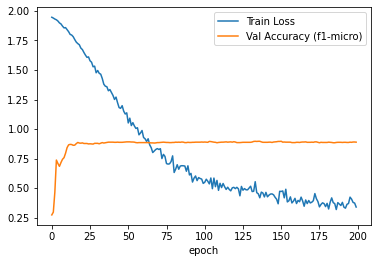

In [79]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.legend(['Train Loss', 'Val Accuracy (f1-micro)'])
plt.xlabel('epoch')
plt.show()

In [80]:
# test the model
print("Testing...")
acc = evaluate(g, features, labels, g.ndata["test_mask"], model)
print("Test accuracy {:.4f}".format(acc))

Testing...
Test accuracy 0.9011
